## Penalized Cox Models  
Cox’s proportional hazard’s model is often an appealing model, because its coefficients can be interpreted in terms of hazard ratio, which often provides valuable insight. However, if we want to estimate the coefficients of many features, the standard Cox model falls apart, because internally it tries to invert a matrix that becomes non-singular due to correlations among features.

### LASSO  
While the ℓ2 (ridge) penalty does solve the mathematical problem of fitting a Cox model, we would still need to measure the expression levels of all 76 genes to make predictions. Ideally, we would like to select a small subset of features that are most predictive and ignore the remaining gene expression levels. This is precisely what the LASSO (Least Absolute Shrinkage and Selection Operator) penalty does. Instead of shrinking coefficients to zero it does a type of continuous subset selection, where a subset of coefficients are set to zero and are effectively excluded. This reduces the number of features that we would need to record for prediction. In mathematical terms, the ℓ2 penalty is replaced by a ℓ1 penalty, which leads to the optimization problem  
$$ \argmax_{β} logPL(β)−α ∑_{j=1} ^p|βj|. $$  
The main challenge is that we cannot directly control the number of features that get selected, but the value of α implicitly determines the number of features. Thus, we need a data-driven way to select a suitable α and obtain a parsimonious model. We can do this by first computing the α that would ignore all features (coefficients are all zero) and then incrementally decrease its value, let’s say until we reach 1% of the original value. This has been implemented in sksurv.linear_model.CoxnetSurvivalAnalysis by specifying l1_ratio=1.0 to use the LASSO penalty and alpha_min_ratio=0.01 to search for 100 α values up to 1% of the estimated maximum.  

In [3]:
# Need some packages installed first
# Microsoft Visual C++ 14.0 or greater is required: http://go.microsoft.com/fwlink/?LinkId=691126&fixForIE=.exe.
!pip install scikit-survival

In [17]:
# install pyparsing in version 3.0.5 (instead 3.0.6)
!pip install -U pyparsing==3.0.5

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util import *
%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### Using breast_cancer dataset for demo
To demonstrate the use of penalized Cox models we are going to use the breast cancer data, which contains the expression levels of 76 genes, age, estrogen receptor status (er), tumor size and grade for 198 individuals. The objective is to predict the time to distant metastasis.

First, we load the data and perform one-hot encoding of categorical variables er and grade.

In [58]:
# load dataset
X, y = load_breast_cancer()
Xt = OneHotEncoder().fit_transform(X)
Xt.round(2).head()

,X200726_at,X200965_s_at,X201068_s_at,X201091_s_at,X201288_at,X201368_at,X201663_s_at,X201664_at,X202239_at,X202240_at,...,X221816_s_at,X221882_s_at,X221916_at,X221928_at,age,er=positive,grade=intermediate,grade=poorly differentiated,grade=unkown,size
0,10.93,8.96,11.63,10.96,11.52,12.04,9.62,9.81,10.02,7.85,...,10.13,10.93,6.48,5.99,57.0,0.0,0.0,1.0,0.0,3.0
1,12.24,9.53,12.63,11.59,12.32,10.78,10.60,10.70,10.16,8.74,...,10.21,9.56,4.97,7.05,57.0,1.0,0.0,1.0,0.0,3.0
2,11.66,10.24,12.57,9.17,11.70,11.35,9.38,10.16,10.03,8.13,...,10.16,9.31,4.28,6.83,48.0,0.0,0.0,1.0,0.0,2.5
3,12.17,9.82,12.11,9.09,13.13,11.86,8.40,8.67,10.73,8.65,...,10.66,10.21,5.71,6.93,42.0,1.0,0.0,1.0,0.0,1.8
4,11.48,11.49,11.78,8.89,10.43,11.40,7.74,8.64,9.56,8.48,...,11.57,10.93,5.82,6.66,46.0,1.0,1.0,0.0,0.0,3.0


In [3]:
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(Xt, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

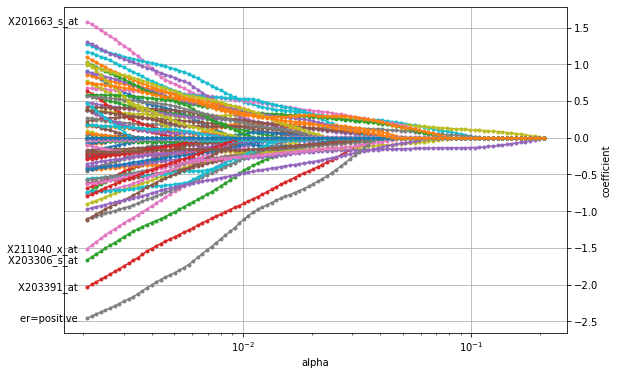

In [4]:
coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=Xt.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=5)

The figure shows that the LASSO penalty indeed selects a small subset of features for large α (to the right) with only two features (purple and yellow line) being non-zero. As α decreases, more and more features become active and are assigned a non-zero coefficient until the entire set of features is used (to the left left). Similar to the plot above for the ridge penalty, the path for X203391_at stands out, indicating its importance in breast cancer. However, the overall most important factor seems to be a positive estrogen receptor status (er).

## Choosing penalty strength α  
Previously, we focused on the estimated coefficients to get some insight into which features are important for estimating time to distant metastasis. However, for prediction, we need to pick one particular α, and the subset of features it implies. Here, we are going to use cross-validation to determine which subset and α generalizes best.

Before we can use GridSearchCV, we need to determine the set of α which we want to evaluate. To do this, we fit a penalized Cox model to the whole data and retrieve the estimated set of alphas. Since, we are only interested in alphas and not the coefficients, we can use only a few iterations for improved speed. Note that we are using StandardScaler to account for scale differences among features and allow direct comparison of coefficients.

In [7]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)
)
warnings.simplefilter("ignore", ConvergenceWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

Using the estimated set of alphas, we perform 5 fold cross-validation to estimate the performance – in terms of concordance index – for each α.

In [8]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

We can visualize the results by plotting the mean concordance index and its standard deviation across all folds for each α.

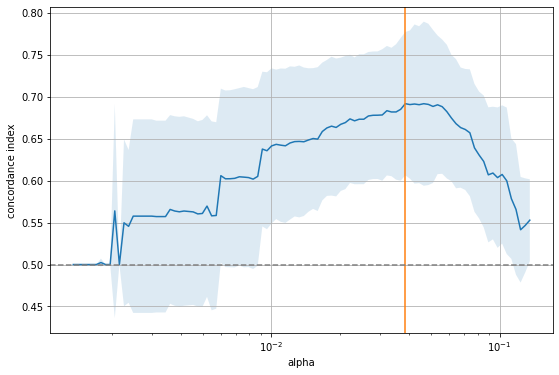

In [7]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

The figure shows that there is a range for α to the right where it is too large and sets all coefficients to zero, as indicated by the 0.5 concordance index of a purely random model. On the other extreme, if α becomes too small, too many features enter the model and the performance approaches that of a random model again. The sweet spot (orange line) is somewhere in the middle. Let’s inspect that model.

Number of non-zero coefficients: 22


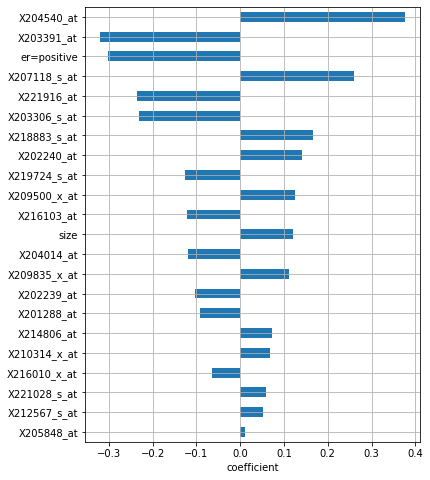

In [67]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xt.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

The model selected a total of 21 features, and it deemed X204540_at to be the most important one, followed by X203391_at and positive estrogen receptor status:

## Survival and Cumulative Hazard Function  
Having selected a particular α, we can perform prediction, either in terms of risk score using the predict function or in terms of survival or cumulative hazard function. For the latter two, we first need to re-fit the model with fit_baseline_model enabled.

In [9]:
coxnet_pred = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.03860196504106796],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

For instance, we can now select a patient and determine how positive or negative estrogen receptor status would affect the survival function.

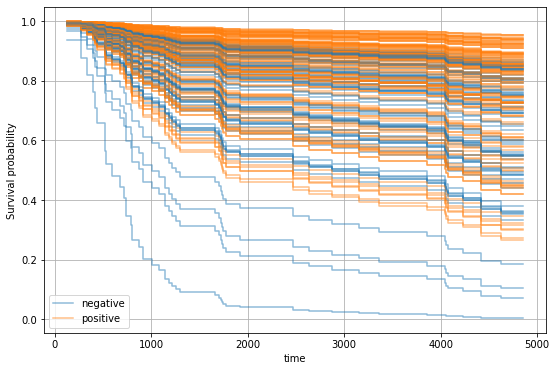

In [10]:
surv_fns = coxnet_pred.predict_survival_function(Xt)

time_points = np.quantile(y["t.tdm"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, Xt.loc[:, "er=positive"].astype(int)):
    line, = ax.step(time_points, fn(time_points), where="post",
                   color="C{:d}".format(label), alpha=0.5)
    if len(legend_handles) <= label:
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

We can observe that patients with positive estrogen receptor status tend to have a better prognosis.

## Using Random Survival Forests  
This notebook demonstrates how to use Random Survival Forests introduced in scikit-survival 0.11.

As it’s popular counterparts for classification and regression, a Random Survival Forest is an ensemble of tree-based learners. A Random Survival Forest ensures that individual trees are de-correlated by 1) building each tree on a different bootstrap sample of the original training data, and 2) at each node, only evaluate the split criterion for a randomly selected subset of features and thresholds. Predictions are formed by aggregating predictions of individual trees in the ensemble.

To demonstrate Random Survival Forest, we are going to use data from the German Breast Cancer Study Group (GBSG-2) on the treatment of node-positive breast cancer patients. It contains data on 686 women and 8 prognostic factors: 1. age, 2. estrogen receptor (estrec), 3. whether or not a hormonal therapy was administered (horTh), 4. menopausal status (menostat), 5. number of positive lymph nodes (pnodes), 6. progesterone receptor (progrec), 7. tumor size (tsize, 8. tumor grade (tgrade).

The goal is to predict recurrence-free survival time.

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

First, we need to load the data and transform it into numeric values.

In [69]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt = np.column_stack((Xt.values, grade_num))

feature_names = X_no_grade.columns.tolist() + ["tgrade"]

Next, the data is split into 75% for training and 25% for testing, so we can determine how well our model generalizes.

In [70]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.25, random_state=random_state)

## Training  
Several split criterion have been proposed in the past, but the most widespread one is based on the log-rank test, which you probably know from comparing survival curves among two or more groups. Using the training data, we fit a Random Survival Forest comprising 1000 trees.

In [71]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=20)

We can check how well the model performs by evaluating it on the test data.

In [72]:
rsf.score(X_test, y_test)

0.6759696016771488

This gives a concordance index of 0.68, which is a good a value and matches the results reported in the Random Survival Forests paper.  
## Predicting  
For prediction, a sample is dropped down each tree in the forest until it reaches a terminal node. Data in each terminal is used to non-parametrically estimate the survival and cumulative hazard function using the Kaplan-Meier and Nelson-Aalen estimator, respectively. In addition, a risk score can be computed that represents the expected number of events for one particular terminal node. The ensemble prediction is simply the average across all trees in the forest.

Let’s first select a couple of patients from the test data according to the number of positive lymph nodes and age.

In [16]:
a = np.empty(X_test.shape[0], dtype=[("age", float), ("pnodes", float)])
a["age"] = X_test[:, 0]
a["pnodes"] = X_test[:, 4]

sort_idx = np.argsort(a, order=["pnodes", "age"])
X_test_sel = pd.DataFrame(
    X_test[np.concatenate((sort_idx[:3], sort_idx[-3:]))],
    columns=feature_names)

X_test_sel

,age,estrec,horTh,menostat,pnodes,progrec,tsize,tgrade
0,33.0,0.0,0.0,0.0,1.0,26.0,35.0,2.0
1,34.0,37.0,0.0,0.0,1.0,0.0,40.0,2.0
2,36.0,14.0,0.0,0.0,1.0,76.0,36.0,1.0
3,65.0,64.0,0.0,1.0,26.0,2.0,70.0,2.0
4,80.0,59.0,0.0,1.0,30.0,0.0,39.0,1.0
5,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0


The predicted risk scores indicate that risk for the last three patients is quite a bit higher than that of the first three patients.

In [17]:
pd.Series(rsf.predict(X_test_sel))

0     91.477609
1    102.897552
2     75.883786
3    170.502092
4    171.210066
5    148.691835
dtype: float64

We can have a more detailed insight by considering the predicted survival function. It shows that the biggest difference occurs roughly within the first 750 days.

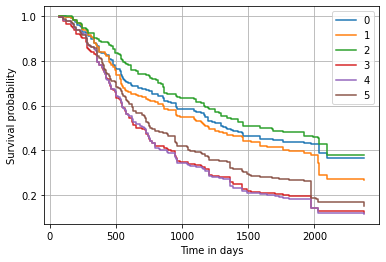

In [18]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

Alternatively, we can also plot the predicted cumulative hazard function.

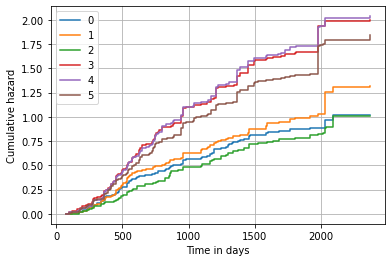

In [19]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

## Permutation-based Feature Importance  
The implementation is based on scikit-learn’s Random Forest implementation and inherits many features, such as building trees in parallel. What’s currently missing is feature importances via the feature_importance_ attribute. This is due to the way scikit-learn’s implementation computes importances. It relies on a measure of impurity for each child node, and defines importance as the amount of decrease in impurity due to a split. For traditional regression, impurity would be measured by the variance, but for survival analysis there is no per-node impurity measure due to censoring. Instead, one could use the magnitude of the log-rank test statistic as an importance measure, but scikit-learn’s implementation doesn’t seem to allow this.

Fortunately, this is not a big concern though, as scikit-learn’s definition of feature importance is non-standard and differs from what Leo Breiman proposed in the original Random Forest paper. Instead, we can use permutation to estimate feature importance, which is preferred over scikit-learn’s definition. This is implemented in the ELI5 library, which is fully compatible with scikit-survival.

In [73]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state=random_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.0676 ± 0.0229,pnodes
0.0206 ± 0.0139,age
0.0177 ± 0.0468,progrec
0.0086 ± 0.0098,horTh
0.0032 ± 0.0198,tsize
0.0032 ± 0.0060,tgrade
-0.0007 ± 0.0018,menostat
-0.0063 ± 0.0207,estrec


The result shows that the number of positive lymph nodes (pnodes) is by far the most important feature. If its relationship to survival time is removed (by random shuffling), the concordance index on the test data drops on average by 0.0676 points. Again, this agrees with the results from the original Random Survival Forests paper.

Details see "scikit-survival" documents: https://scikit-survival.readthedocs.io/en/stable/index.html